# Tweet Sentiment Analysis with Emoji Support

This notebook implements a complete sentiment analysis pipeline for tweets that can handle both text and emojis.

## Dataset Overview:
- **Sentiment140**: 1.6M labeled tweets (positive/negative)
- **Emoji Sentiment Data**: Emoji sentiment scores from social media analysis

## 1. Import Libraries and Setup

In [22]:
# Install required packages
%pip install -q emoji scikit-learn matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


In [23]:
import pandas as pd
import numpy as np
import re
import pickle
import emoji
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

## 2. Load and Explore Datasets

In [24]:
pd.set_option('display.max_columns', None)

In [25]:
# Load Sentiment140 dataset
# Format: sentiment(0=negative, 4=positive), id, date, query, user, text
columns = ['sentiment', 'id', 'date', 'query', 'user', 'text']
sentiment140_df = pd.read_csv('data/tweets/training.1600000.processed.noemoticon.csv', 
                             names=columns, encoding='latin-1')

print(f"Sentiment140 dataset shape: {sentiment140_df.shape}")
print(f"Sentiment distribution:\n{sentiment140_df['sentiment'].value_counts()}")
sentiment140_df.head()

Sentiment140 dataset shape: (1600000, 6)
Sentiment distribution:
sentiment
0    800000
4    800000
Name: count, dtype: int64


,sentiment,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [26]:
# Load emoji sentiment data
emoji_df = pd.read_csv('data/emoji/Emoji_Sentiment_Data_v1.0.csv')
print(f"Emoji dataset shape: {emoji_df.shape}")
emoji_df.head()

Emoji dataset shape: (969, 9)


,Emoji,Unicode codepoint,Occurrences,Position,Negative,Neutral,Positive,Unicode name,Unicode block
0,😂,0x1f602,14622,0.805101,3614,4163,6845,FACE WITH TEARS OF JOY,Emoticons
1,❤,0x2764,8050,0.746943,355,1334,6361,HEAVY BLACK HEART,Dingbats
2,♥,0x2665,7144,0.753806,252,1942,4950,BLACK HEART SUIT,Miscellaneous Symbols
3,😍,0x1f60d,6359,0.765292,329,1390,4640,SMILING FACE WITH HEART-SHAPED EYES,Emoticons
4,😭,0x1f62d,5526,0.803352,2412,1218,1896,LOUDLY CRYING FACE,Emoticons


## 3. Data Preprocessing

In [27]:
# Create emoji sentiment mapping
def create_emoji_sentiment_map(emoji_df):
    """
    Create a mapping of emojis to sentiment scores
    Score calculation: (Positive - Negative) / Total occurrences
    """
    emoji_sentiment = {}
    
    for _, row in emoji_df.iterrows():
        emoji_char = row['Emoji']
        positive = row['Positive']
        negative = row['Negative']
        neutral = row['Neutral']
        total = positive + negative + neutral
        
        if total > 0:
            # Sentiment score: -1 (very negative) to +1 (very positive)
            sentiment_score = (positive - negative) / total
            emoji_sentiment[emoji_char] = sentiment_score
    
    return emoji_sentiment

emoji_sentiment_map = create_emoji_sentiment_map(emoji_df)
print(f"Created emoji sentiment mapping for {len(emoji_sentiment_map)} emojis")

# Show some examples
sorted_emojis = sorted(emoji_sentiment_map.items(), key=lambda x: x[1], reverse=True)
print("\nMost positive emojis:")
for emoji_char, score in sorted_emojis[:5]:
    print(f"{emoji_char}: {score:.3f}")
    
print("\nMost negative emojis:")
for emoji_char, score in sorted_emojis[-5:]:
    print(f"{emoji_char}: {score:.3f}")

Created emoji sentiment mapping for 969 emojis

Most positive emojis:
┊: 1.000
▃: 1.000
🔅: 1.000
🏧: 1.000
🔔: 1.000

Most negative emojis:
🕔: -1.000
🈂: -1.000
🎰: -1.000
҂: -1.000
╤: -1.000


In [28]:
def preprocess_text(text, emoji_sentiment_map):
    """
    Preprocess tweet text with emoji handling
    """
    if pd.isna(text):
        return ""
    
    # Convert to string and lowercase
    text = str(text).lower()
    
    # Extract emoji sentiment features
    emoji_sentiment_score = 0
    emoji_count = 0
    
    # Find emojis and calculate sentiment
    for char in text:
        if char in emoji_sentiment_map:
            emoji_sentiment_score += emoji_sentiment_map[char]
            emoji_count += 1
    
    # Replace emojis with sentiment indicators
    for emoji_char, sentiment_score in emoji_sentiment_map.items():
        if emoji_char in text:
            if sentiment_score > 0.2:
                text = text.replace(emoji_char, ' POSITIVE_EMOJI ')
            elif sentiment_score < -0.2:
                text = text.replace(emoji_char, ' NEGATIVE_EMOJI ')
            else:
                text = text.replace(emoji_char, ' NEUTRAL_EMOJI ')
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove user mentions and hashtags (but keep the text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#', '', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Test the preprocessing function
test_text = "I love this! 😍❤️ But I'm also sad 😭 #happy @user"
processed = preprocess_text(test_text, emoji_sentiment_map)
print(f"Original: {test_text}")
print(f"Processed: {processed}")

Original: I love this! 😍❤️ But I'm also sad 😭 #happy @user
Processed: i love this! POSITIVE_EMOJI POSITIVE_EMOJI ️ but i'm also sad NEUTRAL_EMOJI happy


In [29]:
# Prepare the dataset
# Convert sentiment labels: 0 -> 0 (negative), 4 -> 1 (positive)
sentiment140_df['label'] = sentiment140_df['sentiment'].map({0: 0, 4: 1})

# Use a subset for faster training
# Use full dataset for maximum performance
# sample_size = 200000  
df_sample = sentiment140_df.copy()  # Use full 1.6M dataset

# Preprocess tweets
print("Preprocessing tweets...")
df_sample['processed_text'] = df_sample['text'].apply(lambda x: preprocess_text(x, emoji_sentiment_map))

# Remove empty texts
df_sample = df_sample[df_sample['processed_text'].str.len() > 0]

print(f"Final dataset shape: {df_sample.shape}")
print(f"Label distribution:\n{df_sample['label'].value_counts()}")

Preprocessing tweets...
Final dataset shape: (1597185, 8)
Label distribution:
label
1    798688
0    798497
Name: count, dtype: int64
Final dataset shape: (1597185, 8)
Label distribution:
label
1    798688
0    798497
Name: count, dtype: int64


## 4. Feature Engineering and Model Training

In [30]:
# Split the data
X = df_sample['processed_text']
y = df_sample['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"Training label distribution:\n{y_train.value_counts()}")

Training set size: 1277748
Test set size: 319437
Training label distribution:
label
1    638950
0    638798
Name: count, dtype: int64


In [31]:
# Create and train the model pipeline
print("Training Logistic Regression model...")

# TF-IDF Vectorizer with optimized parameters
tfidf = TfidfVectorizer(
    max_features=50000,  # Limit vocabulary size
    ngram_range=(1, 2),  # Use unigrams and bigrams
    min_df=2,           # Ignore terms that appear in less than 2 documents
    max_df=0.95,        # Ignore terms that appear in more than 95% of documents
    strip_accents='unicode',
    stop_words='english'
)

# Logistic Regression model
lr_model = LogisticRegression(
    random_state=42,
    max_iter=1000,
    C=1.0
)

# Create pipeline
sentiment_pipeline = Pipeline([
    ('tfidf', tfidf),
    ('classifier', lr_model)
])

# Train the model
sentiment_pipeline.fit(X_train, y_train)

print("Model training completed!")

Training Logistic Regression model...
Model training completed!
Model training completed!


## 5. Model Evaluation

In [32]:
# Make predictions
y_pred = sentiment_pipeline.predict(X_test)
y_pred_proba = sentiment_pipeline.predict_proba(X_test)[:, 1]

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

Accuracy: 0.7849

Classification Report:
              precision    recall  f1-score   support

    Negative       0.80      0.76      0.78    159699
    Positive       0.77      0.81      0.79    159738

    accuracy                           0.78    319437
   macro avg       0.79      0.78      0.78    319437
weighted avg       0.79      0.78      0.78    319437



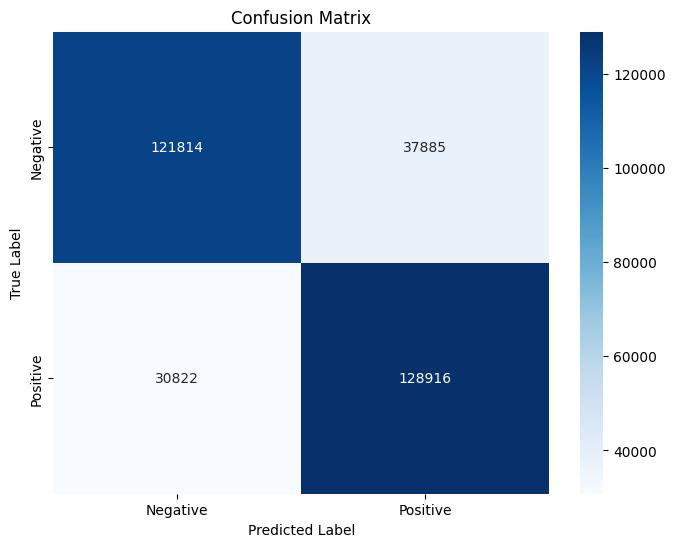


Detailed Metrics:
Precision: 0.7729
Recall: 0.8070
F1-Score: 0.7896
True Negatives: 121814
False Positives: 37885
False Negatives: 30822
True Positives: 128916


In [33]:
# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Calculate additional metrics
tn, fp, fn, tp = cm.ravel()
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)

print(f"\nDetailed Metrics:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")

## 6. Save the Model

In [34]:
# Save the trained model and emoji sentiment mapping
with open('models/tweet_sentiment_model.pkl', 'wb') as f:
    pickle.dump(sentiment_pipeline, f)

with open('models/emoji_sentiment_map.pkl', 'wb') as f:
    pickle.dump(emoji_sentiment_map, f)

print("Model and emoji mapping saved successfully!")
print("Files saved:")
print("- models/tweet_sentiment_model.pkl")
print("- models/emoji_sentiment_map.pkl")

Model and emoji mapping saved successfully!
Files saved:
- models/tweet_sentiment_model.pkl
- models/emoji_sentiment_map.pkl


## 7. Create Prediction Function

In [35]:
def predict_tweet_sentiment(tweet, model_pipeline, emoji_map):
    """
    Predict sentiment for a single tweet
    
    Args:
        tweet (str): The tweet text
        model_pipeline: Trained sentiment analysis pipeline
        emoji_map (dict): Emoji sentiment mapping
    
    Returns:
        dict: Prediction results with sentiment, confidence, and emoji analysis
    """
    # Preprocess the tweet
    processed_tweet = preprocess_text(tweet, emoji_map)
    
    # Make prediction
    prediction = model_pipeline.predict([processed_tweet])[0]
    confidence = model_pipeline.predict_proba([processed_tweet])[0]
    
    # Analyze emojis in the original tweet
    emoji_analysis = []
    for char in tweet:
        if char in emoji_map:
            emoji_analysis.append({
                'emoji': char,
                'sentiment_score': emoji_map[char]
            })
    
    return {
        'original_tweet': tweet,
        'processed_tweet': processed_tweet,
        'sentiment': 'Positive' if prediction == 1 else 'Negative',
        'confidence': {
            'negative': confidence[0],
            'positive': confidence[1]
        },
        'emoji_analysis': emoji_analysis
    }

# Test the prediction function
test_tweets = [
    "I love this movie! 😍❤️ It's absolutely amazing!",
    "This is terrible 😭💔 I hate it so much",
    "Just had lunch 🍕 it was okay I guess",
    "Beautiful sunset today! 🌅✨ Perfect weather for a walk",
    "Stuck in traffic again 😤🚗 This is so frustrating!"
]

print("Testing the model with sample tweets:\n")
for i, tweet in enumerate(test_tweets, 1):
    result = predict_tweet_sentiment(tweet, sentiment_pipeline, emoji_sentiment_map)
    print(f"Tweet {i}: {result['original_tweet']}")
    print(f"Sentiment: {result['sentiment']}")
    print(f"Confidence: {result['confidence']['positive']:.3f} (positive), {result['confidence']['negative']:.3f} (negative)")
    if result['emoji_analysis']:
        print("Emojis found:")
        for emoji_info in result['emoji_analysis']:
            print(f"  {emoji_info['emoji']}: {emoji_info['sentiment_score']:.3f}")
    print("-" * 50)

Testing the model with sample tweets:

Tweet 1: I love this movie! 😍❤️ It's absolutely amazing!
Sentiment: Positive
Confidence: 0.916 (positive), 0.084 (negative)
Emojis found:
  😍: 0.678
  ❤: 0.746
--------------------------------------------------
Tweet 2: This is terrible 😭💔 I hate it so much
Sentiment: Negative
Confidence: 0.118 (positive), 0.882 (negative)
Emojis found:
  😭: -0.093
  💔: -0.122
--------------------------------------------------
Tweet 3: Just had lunch 🍕 it was okay I guess
Sentiment: Negative
Confidence: 0.445 (positive), 0.555 (negative)
Emojis found:
  🍕: 0.420
--------------------------------------------------
Tweet 4: Beautiful sunset today! 🌅✨ Perfect weather for a walk
Sentiment: Positive
Confidence: 0.862 (positive), 0.138 (negative)
Emojis found:
  🌅: 0.381
  ✨: 0.353
--------------------------------------------------
Tweet 5: Stuck in traffic again 😤🚗 This is so frustrating!
Sentiment: Negative
Confidence: 0.011 (positive), 0.989 (negative)
Emojis found:
 

## 8. Model Performance Summary

In [36]:
# Feature importance (top words)
feature_names = sentiment_pipeline.named_steps['tfidf'].get_feature_names_out()
coefficients = sentiment_pipeline.named_steps['classifier'].coef_[0]

# Get top positive and negative features
top_positive_idx = np.argsort(coefficients)[-20:]
top_negative_idx = np.argsort(coefficients)[:20]

print("Top 20 words indicating POSITIVE sentiment:")
for idx in reversed(top_positive_idx):
    print(f"{feature_names[idx]}: {coefficients[idx]:.4f}")

print("\nTop 20 words indicating NEGATIVE sentiment:")
for idx in top_negative_idx:
    print(f"{feature_names[idx]}: {coefficients[idx]:.4f}")

Top 20 words indicating POSITIVE sentiment:
wish luck: 6.7865
don miss: 5.4108
isn bad: 5.3617
thank: 5.3016
wasn bad: 5.2929
thanks: 5.1333
welcome: 5.1249
smiling: 4.8304
don forget: 4.8204
glad: 4.5107
congratulations: 4.4102
don worry: 4.3894
feel free: 4.3112
blessed: 4.2528
congrats: 4.2276
feels good: 4.0990
smile: 4.0801
excited: 4.0691
fuck yeah: 4.0174
life good: 4.0092

Top 20 words indicating NEGATIVE sentiment:
sad: -12.6949
bummed: -7.8065
poor: -7.7053
miss: -7.4010
hurts: -7.0513
sick: -6.9265
sadly: -6.8588
sucks: -6.8258
gutted: -6.8184
disappointing: -6.7459
missing: -6.7138
wish: -6.5953
passed away: -6.4597
headache: -6.3142
unfortunately: -6.2662
depressed: -6.1140
ruined: -6.0197
hate: -6.0024
depressing: -5.8922
ugh: -5.8247


In [37]:
# Final model summary
print("="*60)
print("TWEET SENTIMENT ANALYSIS MODEL SUMMARY")
print("="*60)
print(f"Training Data: {len(X_train):,} tweets")
print(f"Test Data: {len(X_test):,} tweets")
print(f"Vocabulary Size: {len(feature_names):,} features")
print(f"Emoji Mappings: {len(emoji_sentiment_map)} emojis")
print(f"\nModel Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")
print(f"\nModel saved as: tweet_sentiment_model.pkl")
print(f"Emoji mapping saved as: emoji_sentiment_map.pkl")
print("\nThe model can now classify tweets with emojis as positive or negative!")

TWEET SENTIMENT ANALYSIS MODEL SUMMARY
Training Data: 1,277,748 tweets
Test Data: 319,437 tweets
Vocabulary Size: 50,000 features
Emoji Mappings: 969 emojis

Model Performance:
Accuracy: 0.7849
Precision: 0.7729
Recall: 0.8070
F1-Score: 0.7896

Model saved as: tweet_sentiment_model.pkl
Emoji mapping saved as: emoji_sentiment_map.pkl

The model can now classify tweets with emojis as positive or negative!
